In [1]:
import numpy as np
import xarray as xr

import rasterio.features
import stackstac
import pystac_client
import planetary_computer

import xrspatial.multispectral as ms

import pandas as pd
import geopandas as gpd
from datetime import datetime
from shapely.geometry import shape
import shapely
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Step 1

Extract SandSnap data to a pandas dataframe. Clean the dataframe, rename columns and drop unused columns

Clean the date format

In [2]:
marchetti_df = pd.read_csv('../../data/marchetti-sample70.csv')
marchetti_df['date'] =  pd.to_datetime(marchetti_df['date'], infer_datetime_format=True).dt.date
marchetti_df

,objectid,D50,lon,lat,date,category
0,37129,0.038682,10.158621,45.036219,2018-09-22,mud
1,38395,0.046198,10.242807,45.026508,2018-09-22,mud
2,38332,0.042253,10.245731,45.026687,2018-09-22,mud
3,35970,0.020613,10.037174,45.080278,2018-09-22,mud
4,37122,0.021452,10.158875,45.036309,2018-09-22,mud
...,...,...,...,...,...,...
65,8288,22.594687,8.582997,45.128474,2018-09-22,gravel
66,16408,19.872885,9.007106,45.084324,2018-09-22,gravel
67,8547,31.580414,8.587448,45.116245,2018-09-22,gravel
68,16427,12.552355,9.030632,45.084324,2018-09-22,gravel


### Summary stats for grain size params

In [3]:
marchetti_df[['D50']].describe()


,D50
count,70.000000
mean,3.614526
std,8.136437
min,0.004607
25%,0.115153
50%,0.338553
75%,1.283136
max,31.580414


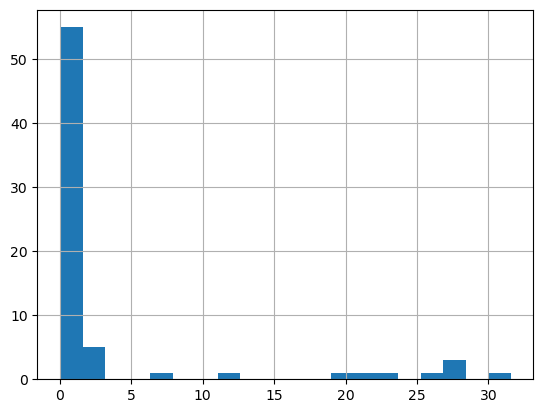

In [4]:
marchetti_df['D50'].hist(bins=20)
plt.show()

In [5]:
marchetti_df.dtypes

objectid      int64
D50         float64
lon         float64
lat         float64
date         object
category     object
dtype: object

## Iterate over each entry and analyze

We will use a naive extraction method, which will be wasteful because these coordinates are likely to be covered by one or few NAIP tiles. But for the sake of simplicity, we will extract the NAIP tile that overlaps with each coordinate, and construct the texture features


In [6]:
side_len_deg = 0.0001 #~11.1m

In [7]:
def bbox(lon, lat, side_len_deg = 0.0001):
    point_geom  = shapely.geometry.mapping(shapely.geometry.Point(lon, lat))
    point_shape = shapely.geometry.shape(point_geom)
    #Create a square out of it with side_length = buffer*2
    mask_shape  = point_shape.buffer(side_len_deg/2.).envelope
    aoi   = shapely.geometry.mapping(mask_shape)
    return aoi
    # return rasterio.features.bounds(aoi)

Using pystac_client we can search the Planetary Computer's STAC endpoint for items matching our query parameters.

In [8]:
collection = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [9]:
#returns the closest date 
def nearest_date(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

To select the nearest time to a desired time value, we set it to use a nearest neighbour method, 'nearest'. We have to specify the time using a datetime object. [ref](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Frequently_used_code/Working_with_time.html)

TODO:
1. Select closest date
2. Check for rainfall near that date - some temporal buffer


In [10]:
import operator

def cropCenter(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

In [11]:
BANDS = ["B04","B03","B02", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]

In [12]:
import pyproj

GSD = 10.0 #m/px

def area_of_overlap(item, aoi):
    area_shape = shape(aoi)
    aoi_area = area_shape.area
    
    
    aoi_area = shape(aoi).area
    
    overlap_area = shape(item.geometry).intersection(shape(aoi)).area
    # print(aoi_area, overlap_area)
    return overlap_area / aoi_area


def S2_data(date, lon, lat, markers, bands = BANDS,\
            limit_months=5, window_size_px=10, add_to_map=None):
    """
    parameters:
    date: datetime object of the time of observation capture
    lon, lat : coordinates of observation
    bands : list of Sentinel 2 band names
    limit_months : maximum duration before and after date to search for
    buffer : area to crop around (lon,lat) in meters, i.e. a square with side buffer
    
    return type:
    window_size_px : if > 1, will return a numpy array DN values at all pixels within window
            if 1, will return a list of DN values per band at that pixel
    """
    
    #Create a window of limit_months around the acquisition date to search for NAIP data
    start_date, end_date = date - relativedelta(months=int(limit_months/2)), \
                            date + relativedelta(months=int(limit_months/2))


    date_range = start_date.strftime('%Y-%m-%d') + "/" + end_date.strftime('%Y-%m-%d')
    
    aoi = bbox(lon, lat)

    search = collection.search(
        # bbox=aoi, 
        intersects=aoi,
        datetime=date_range,
        collections=["sentinel-2-l2a"],
        query={"eo:cloud_cover": {"lt": 10}},
        limit=20,
    )
    
    items = search.item_collection()
    
    if len(items) == 0:
        print ("No tiles found in ", date_range)
        return None
    
    if len(items) > 0:
        tile = items[0]
    else:
        tile = items
    
        
    delta_days = abs((tile.datetime.date() - date).days)
    
    if len(items) > 0:
        delta_min = 1e9
        
        #Choose the item that's closest in time to the sandsnap item's
        for i, item in enumerate(items):
            delta_days = abs((item.datetime.date() - date).days)
            
            if delta_days < delta_min:
                delta_min = delta_days
                tile = item
                
    #Make sure area of overlap is 100%
    if area_of_overlap(tile,aoi) != 1:
        return None
    
    # print("{:} overlapping tile(s) for: {:} | Delta:{:} days"\
    #   .format(len(items),date_range,delta_days))
    
    chosen = stackstac.stack(
        tile,
        assets=bands, 
        # epsg = crs,
        # epsg=3857,
        # chunksize=4096,
        # resolution=100,
    ).where(lambda x: x > 0, other=np.nan).assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names \  # sentinel-2 uses 0 as nodata
    tile = chosen[0] #still has time dimension - removing with this step

    #This is done because the different S2 tiles can have different UTM zones and CRS's
    #that trips up Stackstac -> so choose the epsg as one of them and force them all to be the same
    #OR bypass this process all together and use simple logic to choose the closest date
#     crs = items[0].properties['proj:epsg']
    
#     #convert to xarray with stacstac
#     all_bands = stackstac.stack(
#         items,
#         assets=bands, 
#         epsg = crs,
#         # epsg=3857,
#         # chunksize=4096,
#         # resolution=100,
#     ).where(lambda x: x > 0, other=np.nan).assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names \  # sentinel-2 uses 0 as nodata
    
#     # display(all_bands)
    
#     #Find the one with the closest to date of observation
#     #Doesnt work
#     # return data.sel(time=target_time, method='nearest')
    
#     if all_bands.sizes['time'] > 1: #when the collection (i.e. time dimension) has more than one entry
#         tile = all_bands.sortby(all_bands['eo:cloud_cover'])[0]
#     else:
#         tile = all_bands
    
    # return data
    #Now crop out the AOI:
    x_utm, y_utm = pyproj.Proj(tile.crs)(lon, lat)
    
    #define buffer size in meter to be about 20% larger than required window size
    buffer_m = 100
    window_size_m = window_size_px*GSD
    
    #Make sure buffer isnt too small to correct for skewing of crop box
    buffer_m = window_size_m if window_size_m > buffer_m else buffer_m
    
    aoi = tile.loc[..., y_utm+(buffer_m/2.):y_utm-(buffer_m/2.), x_utm-(buffer_m/2.):x_utm+(buffer_m/2.)]
    # rgb = aoi.sel(band=["red", "green", "blue"])
    aoi = aoi.compute()
    
    # display(aoi)
    aoi_np = aoi.to_numpy()
    
    #Now crop to window size:
    img_patch = cropCenter(aoi_np, (aoi_np.shape[0],window_size_px,window_size_px)) #4 for 4 channels
    
    
    icon = AwesomeIcon(
    name='bus',
    marker_color='red',
    icon_color='black',
    spin=True)

    
    if add_to_map:
        
        stackstac.add_to_map(aoi[0:3], add_to_map, "", range=[0, 3000])
        marker = Marker(icon=icon, location=(lat,lon), draggable=False)
        # marker = ipyleaflet.Marker(location=(lat,lon), draggable=False)
        add_to_map.add_layer(marker);
        
        if(len(markers)>1):
            markers[-1].icon.spin = False
            print ('here')
            
        markers.append(marker)
        
        
        # ipyleaflet.
    
    if img_patch.shape[1] == 1 and img_patch.shape[2] == 1: #i.e. the number of pixels is one
        return img_patch.reshape(len(img_patch)).tolist()
    return (img_patch, delta_days)
    

## Update DF with band values

In [13]:
#drop the first entry, aka outlier with D50 = 3.5mm
# world = world.drop(world.index[0]).reset_index(drop=True)

for band in BANDS:
    marchetti_df[band] = np.NaN
    
marchetti_df['delta_days'] = np.NaN
    
marchetti_df



,objectid,D50,lon,lat,date,category,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12,delta_days
0,37129,0.038682,10.158621,45.036219,2018-09-22,mud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,38395,0.046198,10.242807,45.026508,2018-09-22,mud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,38332,0.042253,10.245731,45.026687,2018-09-22,mud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,35970,0.020613,10.037174,45.080278,2018-09-22,mud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,37122,0.021452,10.158875,45.036309,2018-09-22,mud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,8288,22.594687,8.582997,45.128474,2018-09-22,gravel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,16408,19.872885,9.007106,45.084324,2018-09-22,gravel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,8547,31.580414,8.587448,45.116245,2018-09-22,gravel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,16427,12.552355,9.030632,45.084324,2018-09-22,gravel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm
import time
from IPython.display import clear_output

def get_values(df, m):
    """
    """
    
    keep = False
    marker_list = []
    
    for index, sample in tqdm(df.iterrows(), total=df.shape[0]): #shape is required to tell tqdm the total elements
        m.center = sample['lat'],sample['lon']
        (DNs_point, delta_days) = S2_data(sample['date'], sample['lon'], sample['lat'], window_size_px=200, add_to_map=m, markers=marker_list)
        # time.sleep(10)
        if DNs_point is None:
            print("No tiles for ", sample['objectid'])
            continue
            
        sample['delta_days'] = delta_days
        
        display(sample)
        inp = input("[{:} {:} {:}] Enter y to keep / anything else to discard: ".format(sample['objectid'],  sample['lat'], sample['lon']))
        keep = inp == 'y'  
        # time.sleep(5)
        clear_output()
        
        
        if (keep):
            DNs_point = S2_data(sample['date'], sample['lon'], sample['lat'], window_size_px=1, markers=marker_list)
            print("Kept Observation")
            for b, band in enumerate(BANDS):
                # print(b, band)
                df[band].iloc[index] = DNs_point[b]

        

In [15]:
from dask_gateway import GatewayCluster
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=8, maximum=24)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.4a86caf712e448ffbd36400839eb0361/status


In [16]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.4a86caf712e448ffbd36400839eb0361/status,


In [19]:
import ipyleaflet
import ipyleaflet.basemaps as basemaps
from ipyleaflet import AwesomeIcon, Marker

center = marchetti_df['lat'][0],marchetti_df['lon'][0]
m = ipyleaflet.Map(center=center)
# m = ipyleaflet.Map(basemap=basemaps.Esri.WorldImagery, center=center)

m.zoom = 16
m.layout.height = "700px"
#stackstac.add_to_map(tile1[4:7], m, "s2", range=[0, 3000])
display(m)

Map(center=[45.0362186568, 10.158620727], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_…

In [20]:

# %%time
client.wait_for_workers(2, timeout=10)
get_values(marchetti_df, m)


Kept Observation


In [117]:
marchetti_df

,objectid,D50,lon,lat,date,category,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12
0,37129,0.038682,10.158621,45.036219,2018-09-22,mud,2012.0,1860.0,1598.0,2213.0,2343.0,2448.0,2398.0,2443.0,3095.0,3045.0
1,38395,0.046198,10.242807,45.026508,2018-09-22,mud,2328.0,2132.0,1868.0,2544.0,2593.0,2730.0,2608.0,2719.0,3494.0,3495.0
2,38332,0.042253,10.245731,45.026687,2018-09-22,mud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,35970,0.020613,10.037174,45.080278,2018-09-22,mud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,37122,0.021452,10.158875,45.036309,2018-09-22,mud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,8288,22.594687,8.582997,45.128474,2018-09-22,gravel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,16408,19.872885,9.007106,45.084324,2018-09-22,gravel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,8547,31.580414,8.587448,45.116245,2018-09-22,gravel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,16427,12.552355,9.030632,45.084324,2018-09-22,gravel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Wait for 4 workers for upto 10 seconds

array([[<AxesSubplot:title={'center':'D50'}>]], dtype=object)

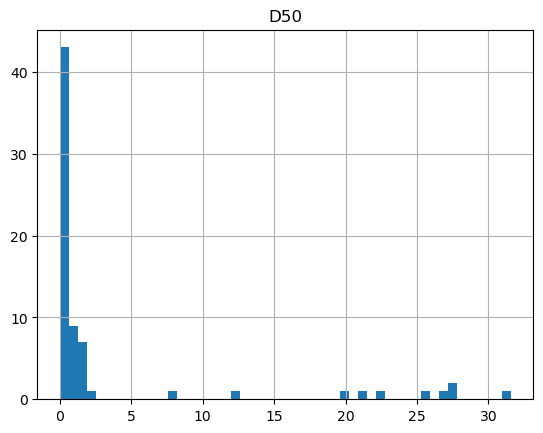

In [21]:
marchetti_df[['D50']].hist(bins=50)

## Multiple regression

### Remove all NaNs

In [96]:
df = marchetti_df[marchetti_df['B02'].notna()].reset_index(drop=True).copy()
df

,objectid,D50,lon,lat,date,category,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12,delta_days
0,37129,0.038682,10.158621,45.036219,2018-09-22,mud,2012.0,1860.0,1598.0,2213.0,2343.0,2448.0,2398.0,2443.0,3095.0,3045.0,NaN
1,38395,0.046198,10.242807,45.026508,2018-09-22,mud,2328.0,2132.0,1868.0,2544.0,2593.0,2730.0,2608.0,2719.0,3494.0,3495.0,NaN
2,38332,0.042253,10.245731,45.026687,2018-09-22,mud,2294.0,2112.0,1838.0,2493.0,2516.0,2608.0,2520.0,2614.0,3477.0,3447.0,NaN
3,35970,0.020613,10.037174,45.080278,2018-09-22,mud,2222.0,2036.0,1714.0,2453.0,2560.0,2695.0,2566.0,2645.0,3326.0,3191.0,NaN
4,37898,0.012462,10.134713,45.030914,2018-09-22,mud,2066.0,1888.0,1650.0,2267.0,2289.0,2401.0,2318.0,2359.0,3128.0,3078.0,NaN
5,39168,0.043707,10.283373,45.003849,2018-09-22,mud,1996.0,1866.0,1584.0,2191.0,2233.0,2281.0,2312.0,2288.0,2996.0,2889.0,NaN
6,30229,0.026007,9.643459,45.109411,2018-09-22,mud,2198.0,2022.0,1708.0,2335.0,2449.0,2531.0,2574.0,2521.0,3089.0,2975.0,NaN
7,34688,0.050359,9.886098,45.112199,2018-09-22,mud,2424.0,2232.0,1914.0,2672.0,2634.0,2720.0,2624.0,2724.0,3507.0,3443.0,NaN
8,34401,0.004607,9.882918,45.117414,2018-09-22,mud,2404.0,2262.0,1976.0,2666.0,2684.0,2788.0,2696.0,2766.0,3641.0,3564.0,NaN
9,35636,0.111953,10.036411,45.081537,2018-09-22,VFS,2186.0,2054.0,1750.0,2399.0,2509.0,2595.0,2534.0,2577.0,3235.0,3142.0,NaN


In [97]:
df.isna().sum()

objectid       0
D50            0
lon            0
lat            0
date           0
category       0
B04            0
B03            0
B02            0
B05            0
B06            0
B07            0
B08            0
B8A            0
B11            0
B12            0
delta_days    52
dtype: int64

## Convert Band values to absolute reflectance

For Sentinel-2 optical data (L2A), the relation between DN and REFLECTANCE (default unit) is: DN = 10000 * REFLECTANCE [Source](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/)

Therefore divide by 10000. to get the reflectance value

In [98]:
df[BANDS] = df[BANDS]/(10000.)
df

,objectid,D50,lon,lat,date,category,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12,delta_days
0,37129,0.038682,10.158621,45.036219,2018-09-22,mud,0.2012,0.1860,0.1598,0.2213,0.2343,0.2448,0.2398,0.2443,0.3095,0.3045,NaN
1,38395,0.046198,10.242807,45.026508,2018-09-22,mud,0.2328,0.2132,0.1868,0.2544,0.2593,0.2730,0.2608,0.2719,0.3494,0.3495,NaN
2,38332,0.042253,10.245731,45.026687,2018-09-22,mud,0.2294,0.2112,0.1838,0.2493,0.2516,0.2608,0.2520,0.2614,0.3477,0.3447,NaN
3,35970,0.020613,10.037174,45.080278,2018-09-22,mud,0.2222,0.2036,0.1714,0.2453,0.2560,0.2695,0.2566,0.2645,0.3326,0.3191,NaN
4,37898,0.012462,10.134713,45.030914,2018-09-22,mud,0.2066,0.1888,0.1650,0.2267,0.2289,0.2401,0.2318,0.2359,0.3128,0.3078,NaN
5,39168,0.043707,10.283373,45.003849,2018-09-22,mud,0.1996,0.1866,0.1584,0.2191,0.2233,0.2281,0.2312,0.2288,0.2996,0.2889,NaN
6,30229,0.026007,9.643459,45.109411,2018-09-22,mud,0.2198,0.2022,0.1708,0.2335,0.2449,0.2531,0.2574,0.2521,0.3089,0.2975,NaN
7,34688,0.050359,9.886098,45.112199,2018-09-22,mud,0.2424,0.2232,0.1914,0.2672,0.2634,0.2720,0.2624,0.2724,0.3507,0.3443,NaN
8,34401,0.004607,9.882918,45.117414,2018-09-22,mud,0.2404,0.2262,0.1976,0.2666,0.2684,0.2788,0.2696,0.2766,0.3641,0.3564,NaN
9,35636,0.111953,10.036411,45.081537,2018-09-22,VFS,0.2186,0.2054,0.1750,0.2399,0.2509,0.2595,0.2534,0.2577,0.3235,0.3142,NaN


## Save file to disk

In [27]:
df.to_csv('../../data/marchetti-reflectance-51.csv')

## Regress D50/D90/D10

In [89]:
import statsmodels.formula.api as smf 
#["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
# formula: response ~ predictor + predictor 
model = smf.ols(formula='D50 ~ B02 + B03 + B04 + B05 + B06 + B07 + B08 + B8A + B11 + B12', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                 -0.044
Method:                 Least Squares   F-statistic:                    0.7981
Date:                Sat, 18 Mar 2023   Prob (F-statistic):              0.631
Time:                        04:30:01   Log-Likelihood:                -71.253
No. Observations:                  49   AIC:                             164.5
Df Residuals:                      38   BIC:                             185.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0043      2.586      1.162      0.253      -2.230       8.238
B02            0.0299     60.241      0.000      1.000    -121.921     121.981
B03          -57.9810     73.240     -0.792      0.433    -206.249      90.287
B04           25.3171     40.282      0.628      0.533     -56.230     106.864
B05           50.8982     47.097      1.081      0.287     -44.445     146.241
B06          -60.1661     87.413     -0.688      0.495    -237.124     116.792
B07          -39.2476     91.954     -0.427      0.672    -225.399     146.903
B08           22.8935     33.988      0.674      0.505     -45.911      91.698
B8A           51.2291     79.728      0.643      0.524    -110.172     212.631
B11           19.1379     59.593      0.321      0.750    -101.502     139.778
B12          -27.3091     38.437     -0.710      0.482    -105.121      50.503
==============================================================================
Omnibus:                       79.530   Durbin-Watson:                   1.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1299.287
Skew:                           4.214   Prob(JB):                    7.30e-283
Kurtosis:                      26.777   Cond. No.                         891.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
import statsmodels.formula.api as smf 
#["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
# formula: response ~ predictor + predictor 
model = smf.ols(formula='D50 ~ B02 + B04 + B11 + B12', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     1.605
Date:                Sat, 18 Mar 2023   Prob (F-statistic):              0.190
Time:                        04:30:11   Log-Likelihood:                -72.587
No. Observations:                  49   AIC:                             155.2
Df Residuals:                      44   BIC:                             164.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6322      2.263      1.163      0.251      -1.928       7.193
B02          -49.2649     30.395     -1.621      0.112    -110.522      11.992
B04           31.6895     21.355      1.484      0.145     -11.349      74.728
B11           12.8364     20.757      0.618      0.539     -28.996      54.669
B12          -14.6966     18.049     -0.814      0.420     -51.073      21.680
==============================================================================
Omnibus:                       82.322   Durbin-Watson:                   1.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1407.422
Skew:                           4.443   Prob(JB):                    2.41e-306
Kurtosis:                      27.706   Cond. No.                         253.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     5.101
Date:                Sat, 18 Mar 2023   Prob (F-statistic):             0.0283
Time:                        03:40:39   Log-Likelihood:                -160.12
No. Observations:                  52   AIC:                             324.2
Df Residuals:                      50   BIC:                             328.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.3027      6.825      2.535      0.014       3.594      31.012
B02          -89.7262     39.726     -2.259      0.028    -169.518      -9.935
==============================================================================
Omnibus:                       66.495   Durbin-Watson:                   0.579
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              469.005
Skew:                           3.544   Prob(JB):                    1.43e-102
Kurtosis:                      15.893   Cond. No.                         54.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     3.120
Date:                Sat, 18 Mar 2023   Prob (F-statistic):             0.0834
Time:                        03:40:40   Log-Likelihood:                -161.08
No. Observations:                  52   AIC:                             326.2
Df Residuals:                      50   BIC:                             330.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.3614      7.615      2.017      0.049       0.067      30.656
B03          -66.4797     37.638     -1.766      0.083    -142.078       9.118
==============================================================================
Omnibus:                       66.505   Durbin-Watson:                   0.491
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              453.640
Skew:                           3.574   Prob(JB):                     3.11e-99
Kurtosis:                      15.581   Cond. No.                         51.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     4.401
Date:                Sat, 18 Mar 2023   Prob (F-statistic):             0.0410
Time:                        03:40:40   Log-Likelihood:                -160.46
No. Observations:                  52   AIC:                             324.9
Df Residuals:                      50   BIC:                             328.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.5881      7.004      2.368      0.022       2.520      30.656
B04          -66.9835     31.928     -2.098      0.041    -131.113      -2.854
==============================================================================
Omnibus:                       65.107   Durbin-Watson:                   0.535
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              435.093
Skew:                           3.472   Prob(JB):                     3.32e-95
Kurtosis:                      15.353   Cond. No.                         44.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     3.176
Date:                Sat, 18 Mar 2023   Prob (F-statistic):             0.0808
Time:                        03:40:40   Log-Likelihood:                -161.05
No. Observations:                  52   AIC:                             326.1
Df Residuals:                      50   BIC:                             330.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.4570      7.043      2.053      0.045       0.312      28.602
B05          -52.5087     29.463     -1.782      0.081    -111.687       6.669
==============================================================================
Omnibus:                       67.711   Durbin-Watson:                   0.479
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              488.595
Skew:                           3.629   Prob(JB):                    8.00e-107
Kurtosis:                      16.147   Cond. No.                         41.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.289
Date:                Sat, 18 Mar 2023   Prob (F-statistic):              0.137
Time:                        03:40:40   Log-Likelihood:                -161.49
No. Observations:                  52   AIC:                             327.0
Df Residuals:                      50   BIC:                             330.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.7183      8.454      1.741      0.088      -2.263      31.700
B06          -51.9931     34.363     -1.513      0.137    -121.013      17.026
==============================================================================
Omnibus:                       69.326   Durbin-Watson:                   0.450
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              519.957
Skew:                           3.735   Prob(JB):                    1.24e-113
Kurtosis:                      16.571   Cond. No.                         47.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.812
Date:                Sat, 18 Mar 2023   Prob (F-statistic):              0.184
Time:                        03:40:40   Log-Likelihood:                -161.72
No. Observations:                  52   AIC:                             327.4
Df Residuals:                      50   BIC:                             331.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.1944      8.368      1.577      0.121      -3.612      30.001
B07          -43.7482     32.501     -1.346      0.184    -109.028      21.531
==============================================================================
Omnibus:                       68.619   Durbin-Watson:                   0.419
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              495.736
Skew:                           3.706   Prob(JB):                    2.25e-108
Kurtosis:                      16.185   Cond. No.                         45.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                 0.0003493
Date:                Sat, 18 Mar 2023   Prob (F-statistic):              0.985
Time:                        03:40:40   Log-Likelihood:                -162.65
No. Observations:                  52   AIC:                             329.3
Df Residuals:                      50   BIC:                             333.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1739     10.482      0.207      0.837     -18.880      23.228
B08           -0.7729     41.354     -0.019      0.985     -83.835      82.290
==============================================================================
Omnibus:                       67.000   Durbin-Watson:                   0.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              433.535
Skew:                           3.664   Prob(JB):                     7.23e-95
Kurtosis:                      15.099   Cond. No.                         56.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.634
Date:                Sat, 18 Mar 2023   Prob (F-statistic):              0.207
Time:                        03:40:40   Log-Likelihood:                -161.81
No. Observations:                  52   AIC:                             327.6
Df Residuals:                      50   BIC:                             331.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.1509      7.996      1.520      0.135      -3.909      28.211
B8A          -39.6950     31.057     -1.278      0.207    -102.076      22.686
==============================================================================
Omnibus:                       68.506   Durbin-Watson:                   0.409
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              490.943
Skew:                           3.704   Prob(JB):                    2.47e-107
Kurtosis:                      16.104   Cond. No.                         43.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     8.413
Date:                Sat, 18 Mar 2023   Prob (F-statistic):            0.00552
Time:                        03:40:40   Log-Likelihood:                -158.61
No. Observations:                  52   AIC:                             321.2
Df Residuals:                      50   BIC:                             325.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.5453      7.471      3.152      0.003       8.540      38.550
B11          -66.3350     22.870     -2.900      0.006    -112.271     -20.399
==============================================================================
Omnibus:                       67.057   Durbin-Watson:                   0.690
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              512.886
Skew:                           3.524   Prob(JB):                    4.25e-112
Kurtosis:                      16.677   Cond. No.                         35.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     20.46
Date:                Sat, 18 Mar 2023   Prob (F-statistic):           3.77e-05
Time:                        03:40:40   Log-Likelihood:                -153.73
No. Observations:                  52   AIC:                             311.5
Df Residuals:                      50   BIC:                             315.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.0294      5.358      4.858      0.000      15.268      36.791
B12          -76.7837     16.976     -4.523      0.000    -110.881     -42.686
==============================================================================
Omnibus:                       55.185   Durbin-Watson:                   0.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              316.737
Skew:                           2.797   Prob(JB):                     1.67e-69
Kurtosis:                      13.719   Cond. No.                         28.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]]


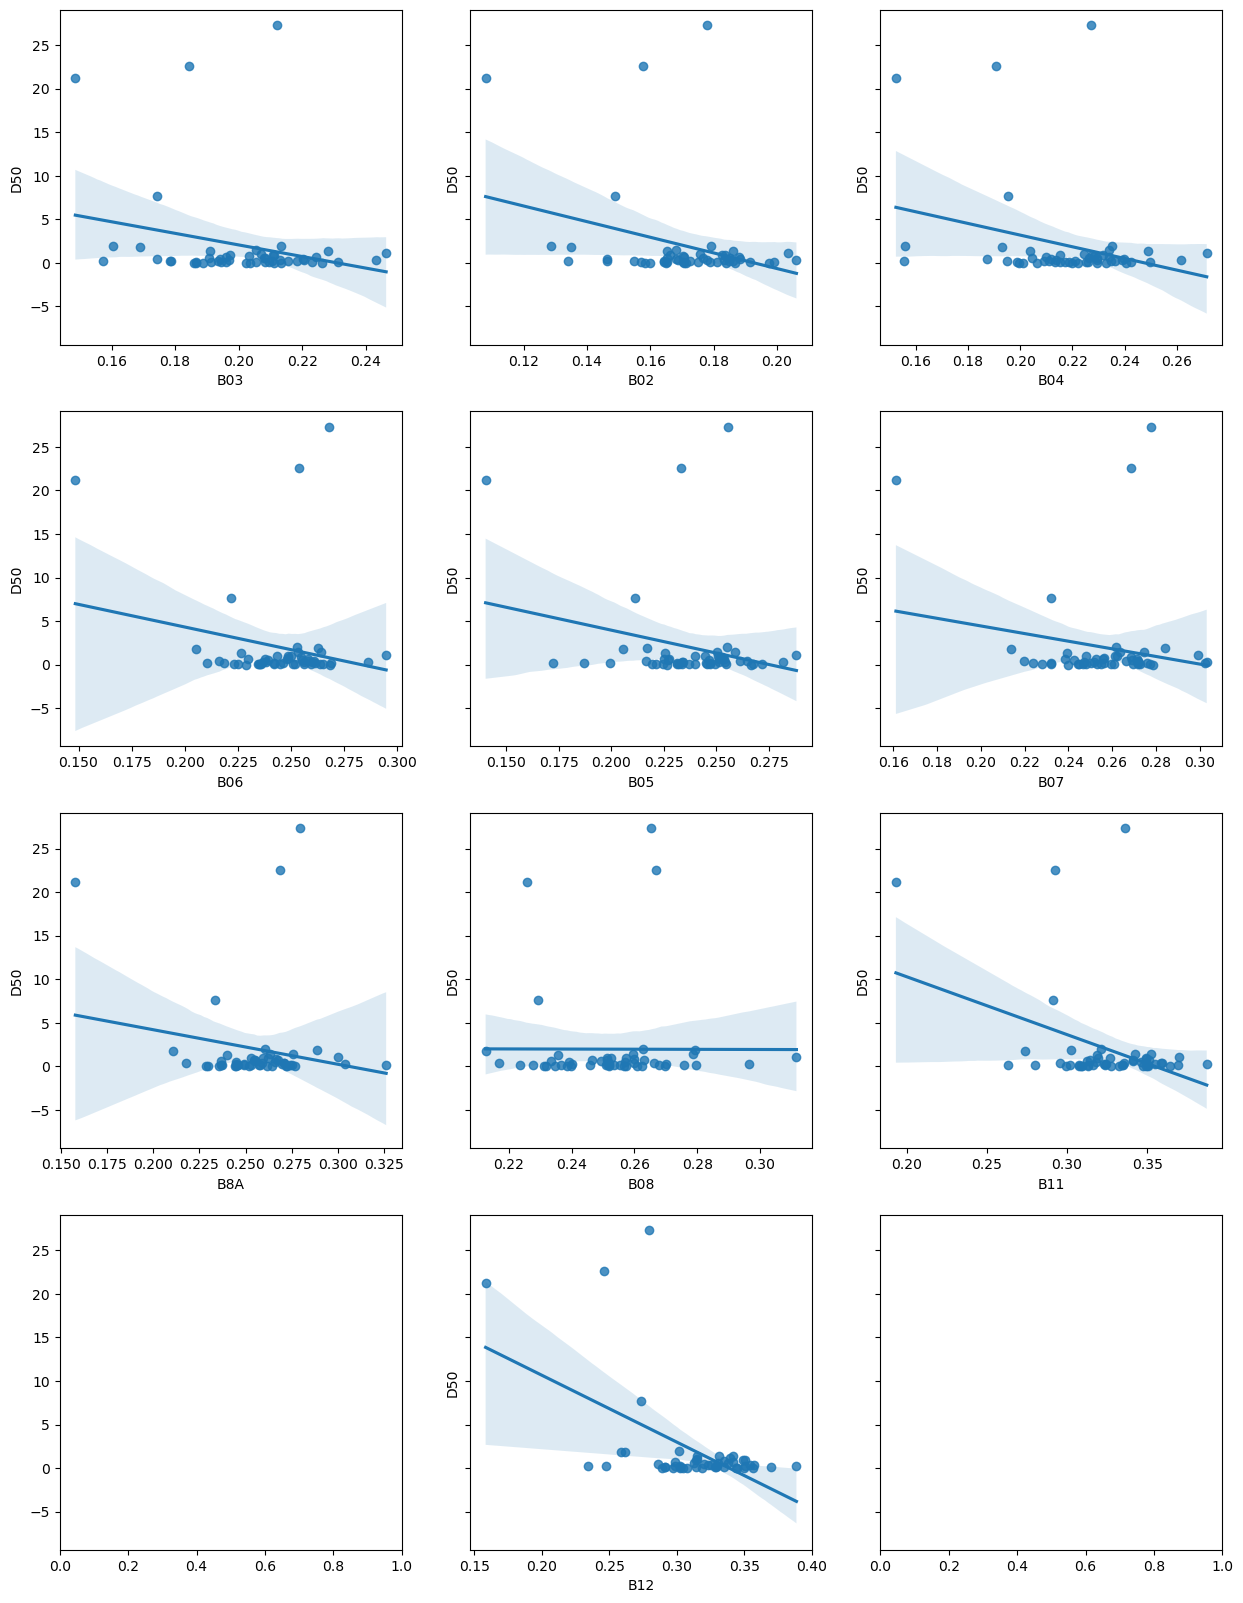

In [30]:
model = smf.ols(formula='D50 ~ B02', data=df).fit()
display(model.summary())
model = smf.ols(formula='D50 ~ B03', data=df).fit()
display(model.summary())
model = smf.ols(formula='D50 ~ B04', data=df).fit()
display(model.summary())
model = smf.ols(formula='D50 ~ B05', data=df).fit()
display(model.summary())
model = smf.ols(formula='D50 ~ B06', data=df).fit()
display(model.summary())
model = smf.ols(formula='D50 ~ B07', data=df).fit()
display(model.summary())
model = smf.ols(formula='D50 ~ B08', data=df).fit()
display(model.summary())
model = smf.ols(formula='D50 ~ B8A', data=df).fit()
display(model.summary())
model = smf.ols(formula='D50 ~ B11', data=df).fit()
display(model.summary())
model = smf.ols(formula='D50 ~ B12', data=df).fit()
display(model.summary())

fig, axs = plt.subplots(4, 3, sharey=True, figsize=(15,20))

print(axs)

sns.regplot(x='B02', y='D50', data=df, ax=axs[0][1])
sns.regplot(x='B03', y='D50', data=df, ax=axs[0][0])
sns.regplot(x='B04', y='D50', data=df, ax=axs[0][2])
sns.regplot(x='B05', y='D50', data=df, ax=axs[1][1])
sns.regplot(x='B06', y='D50', data=df, ax=axs[1][0])
sns.regplot(x='B07', y='D50', data=df, ax=axs[1][2])
sns.regplot(x='B08', y='D50', data=df, ax=axs[2][1])
sns.regplot(x='B8A', y='D50', data=df, ax=axs[2][0])
sns.regplot(x='B11', y='D50', data=df, ax=axs[2][2])
sns.regplot(x='B12', y='D50', data=df, ax=axs[3][1])

plt.show()

# Random Forest Regression

Clearly no linearity can be found at these spatial scale (0.6m). This is likely telling us that the texture features are all but lost at this resolution for detecting particle sizes of this size (<2mm)

In [31]:
y = df['D50']
X = df[BANDS]
display(X)
display(y)
type(y)

,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12
0,0.2012,0.1860,0.1598,0.2213,0.2343,0.2448,0.2398,0.2443,0.3095,0.3045
1,0.2328,0.2132,0.1868,0.2544,0.2593,0.2730,0.2608,0.2719,0.3494,0.3495
2,0.2294,0.2112,0.1838,0.2493,0.2516,0.2608,0.2520,0.2614,0.3477,0.3447
3,0.2222,0.2036,0.1714,0.2453,0.2560,0.2695,0.2566,0.2645,0.3326,0.3191
4,0.2066,0.1888,0.1650,0.2267,0.2289,0.2401,0.2318,0.2359,0.3128,0.3078
5,0.1996,0.1866,0.1584,0.2191,0.2233,0.2281,0.2312,0.2288,0.2996,0.2889
6,0.2198,0.2022,0.1708,0.2335,0.2449,0.2531,0.2574,0.2521,0.3089,0.2975
7,0.2424,0.2232,0.1914,0.2672,0.2634,0.2720,0.2624,0.2724,0.3507,0.3443
8,0.2404,0.2262,0.1976,0.2666,0.2684,0.2788,0.2696,0.2766,0.3641,0.3564
9,0.2186,0.2054,0.1750,0.2399,0.2509,0.2595,0.2534,0.2577,0.3235,0.3142


0      0.038682
1      0.046198
2      0.042253
3      0.020613
4      0.012462
5      0.043707
6      0.026007
7      0.050359
8      0.004607
9      0.111953
10     0.083931
11     0.119718
12     0.113666
13     0.113616
14     0.115378
15     0.067173
16     0.215409
17     0.213121
18     0.218119
19     0.153947
20     0.183857
21     0.193586
22     0.393507
23     0.291381
24     0.443275
25     0.490857
26     0.388205
27     0.276279
28     0.351617
29     0.325489
30     0.277576
31     0.940762
32     0.885235
33     0.791844
34     0.613624
35     0.684416
36     0.545035
37     0.964099
38     0.997013
39     0.594469
40     0.686784
41     1.893002
42     1.426681
43     1.336302
44     1.993319
45     1.409543
46     1.123639
47     1.817215
48     7.653986
49    27.312010
50    22.594687
51    21.191771
Name: D50, dtype: float64

pandas.core.series.Series

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [33]:
X_test

,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12
19,0.2250,0.2096,0.1812,0.2451,0.2463,0.2563,0.2520,0.2573,0.3344,0.3351
41,0.1560,0.1604,0.1286,0.2168,0.2626,0.2840,0.2792,0.2887,0.3023,0.2587
47,0.1932,0.1688,0.1350,0.2056,0.2054,0.2138,0.2126,0.2105,0.2738,0.2619
12,0.2258,0.2084,0.1788,0.2471,0.2419,0.2549,0.2458,0.2494,0.3348,0.3285
43,0.2038,0.1910,0.1652,0.2255,0.2265,0.2395,0.2358,0.2402,0.3188,0.3147
5,0.1996,0.1866,0.1584,0.2191,0.2233,0.2281,0.2312,0.2288,0.2996,0.2889
17,0.2364,0.2182,0.1862,0.2471,0.2610,0.2758,0.2796,0.2752,0.3507,0.3301
50,0.1908,0.1844,0.1576,0.2329,0.2536,0.2686,0.2668,0.2688,0.2924,0.2459
3,0.2222,0.2036,0.1714,0.2453,0.2560,0.2695,0.2566,0.2645,0.3326,0.3191
32,0.2276,0.2108,0.1836,0.2526,0.2547,0.2685,0.2598,0.2666,0.3495,0.3490


In [34]:
# Train the model
rf = RandomForestRegressor(n_estimators = 10, max_depth = 10, random_state = 42)
rf.fit(X_train, y_train.values.ravel())

RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42)

In [35]:
import warnings
warnings.filterwarnings('ignore')

# Make prediction
predictions = rf.predict(X_test)

result = X_test.copy()
result['D50'] = y_test
result['D50_pred'] = predictions.tolist()
result.head()

,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12,D50,D50_pred
19,0.2250,0.2096,0.1812,0.2451,0.2463,0.2563,0.2520,0.2573,0.3344,0.3351,0.153947,0.696157
41,0.1560,0.1604,0.1286,0.2168,0.2626,0.2840,0.2792,0.2887,0.3023,0.2587,1.893002,3.668099
47,0.1932,0.1688,0.1350,0.2056,0.2054,0.2138,0.2126,0.2105,0.2738,0.2619,1.817215,4.613249
12,0.2258,0.2084,0.1788,0.2471,0.2419,0.2549,0.2458,0.2494,0.3348,0.3285,0.113666,0.548609
43,0.2038,0.1910,0.1652,0.2255,0.2265,0.2395,0.2358,0.2402,0.3188,0.3147,1.336302,0.423447


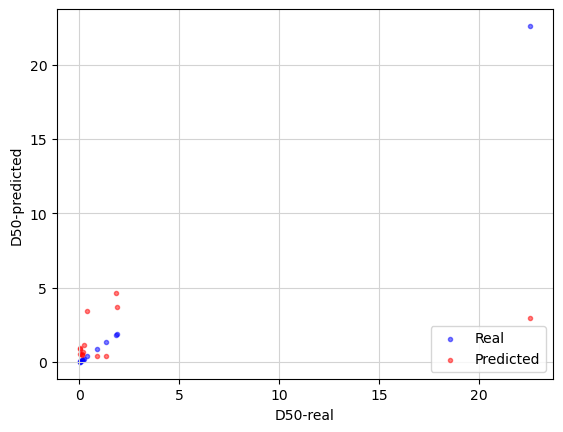

In [36]:
import matplotlib.pyplot as plt

# Define x axis
x_axis = result.D50

# Build scatterplot
plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('D50-real')
plt.ylabel('D50-predicted')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()



## Tuning hyperparameters

In [37]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Find the best parameters for the model
parameters = {
    'max_depth': [70, 80, 90, 100],
    'n_estimators': [100, 500, 1000]
}
gridforest = GridSearchCV(rf, parameters, cv = 3, n_jobs = -1, verbose = 1)
gridforest.fit(X_train, y_train)
gridforest.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


{'max_depth': 70, 'n_estimators': 1000}

In [40]:
rf = RandomForestRegressor(n_estimators = 1000, max_depth = 70, random_state = 42)
rf.fit(X_train, y_train.values.ravel())


RandomForestRegressor(max_depth=70, n_estimators=1000, random_state=42)

In [89]:
X_test

,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12
0,0.1344,0.1254,0.1046,0.1382,0.1379,0.1403,0.1384,0.1391,0.2001,0.1917
1,0.1480,0.1352,0.1158,0.1486,0.1446,0.1468,0.1518,0.1412,0.2030,0.1964
5,0.1656,0.1534,0.1266,0.1727,0.1770,0.1865,0.1894,0.1808,0.2566,0.2401
14,0.2758,0.2502,0.2238,0.2754,0.2590,0.2763,0.3066,0.2705,0.3496,0.3340


In [41]:
# Make prediction
predictions = rf.predict(X_test)

result = X_test.copy()
result['D50'] = y_test
result['D50_pred'] = predictions.tolist()
result.head()

,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12,D50,D50_pred
19,0.2250,0.2096,0.1812,0.2451,0.2463,0.2563,0.2520,0.2573,0.3344,0.3351,0.153947,0.667201
41,0.1560,0.1604,0.1286,0.2168,0.2626,0.2840,0.2792,0.2887,0.3023,0.2587,1.893002,7.549448
47,0.1932,0.1688,0.1350,0.2056,0.2054,0.2138,0.2126,0.2105,0.2738,0.2619,1.817215,6.693622
12,0.2258,0.2084,0.1788,0.2471,0.2419,0.2549,0.2458,0.2494,0.3348,0.3285,0.113666,0.531520
43,0.2038,0.1910,0.1652,0.2255,0.2265,0.2395,0.2358,0.2402,0.3188,0.3147,1.336302,0.410473


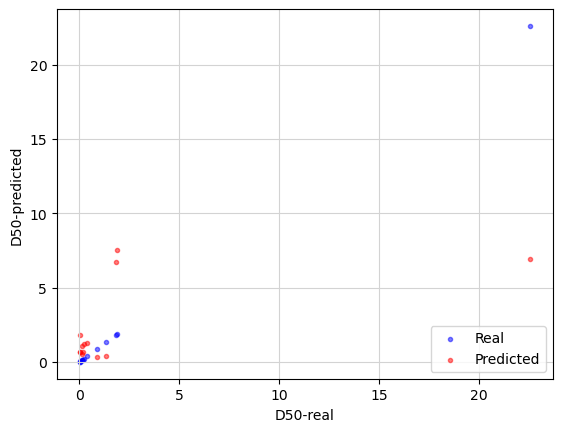

In [42]:
# Define x axis
x_axis = result.D50

# Build scatterplot
plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('D50-real')
plt.ylabel('D50-predicted')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()



## Error Estimation

In [65]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))
print('R-squared scores:', round(r2, 2))



Mean Absolute Error: 0.91
Mean Squared Error: 1.05
R-squared scores: -0.64


## Defining and visualizing variables importance

In [66]:
# Get features list
characteristics = X.columns
# Get the variables importances, sort them, and print the result
importances = list(rf.feature_importances_)
characteristics_importances = [(characteristic, round(importance, 2)) for characteristic, importance in zip(characteristics, importances)]
characteristics_importances = sorted(characteristics_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in characteristics_importances];

Variable: B12                  Importance: 0.22
Variable: B02                  Importance: 0.2
Variable: B08                  Importance: 0.2
Variable: B03                  Importance: 0.1
Variable: B11                  Importance: 0.1
Variable: B06                  Importance: 0.08
Variable: B07                  Importance: 0.07
Variable: B04                  Importance: 0.01
Variable: B05                  Importance: 0.01
Variable: B8A                  Importance: 0.01


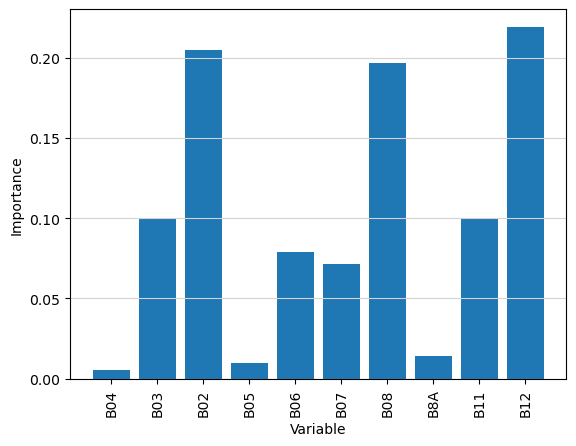

In [67]:
# Visualize the variables importances
plt.bar(characteristics, importances, orientation = 'vertical')
plt.xticks(rotation = 'vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.grid(axis = 'y', color = '#D3D3D3', linestyle = 'solid')
plt.show()

# Categorical prediction

In [95]:
df2 = df.copy()
df2

,objectid,D50,lon,lat,date,category,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12,delta_days
0,37129,0.038682,10.158621,45.036219,2018-09-22,mud,0.2012,0.1860,0.1598,0.2213,0.2343,0.2448,0.2398,0.2443,0.3095,0.3045,NaN
1,38395,0.046198,10.242807,45.026508,2018-09-22,mud,0.2328,0.2132,0.1868,0.2544,0.2593,0.2730,0.2608,0.2719,0.3494,0.3495,NaN
2,38332,0.042253,10.245731,45.026687,2018-09-22,mud,0.2294,0.2112,0.1838,0.2493,0.2516,0.2608,0.2520,0.2614,0.3477,0.3447,NaN
3,35970,0.020613,10.037174,45.080278,2018-09-22,mud,0.2222,0.2036,0.1714,0.2453,0.2560,0.2695,0.2566,0.2645,0.3326,0.3191,NaN
4,37898,0.012462,10.134713,45.030914,2018-09-22,mud,0.2066,0.1888,0.1650,0.2267,0.2289,0.2401,0.2318,0.2359,0.3128,0.3078,NaN
5,39168,0.043707,10.283373,45.003849,2018-09-22,mud,0.1996,0.1866,0.1584,0.2191,0.2233,0.2281,0.2312,0.2288,0.2996,0.2889,NaN
6,30229,0.026007,9.643459,45.109411,2018-09-22,mud,0.2198,0.2022,0.1708,0.2335,0.2449,0.2531,0.2574,0.2521,0.3089,0.2975,NaN
7,34688,0.050359,9.886098,45.112199,2018-09-22,mud,0.2424,0.2232,0.1914,0.2672,0.2634,0.2720,0.2624,0.2724,0.3507,0.3443,NaN
8,34401,0.004607,9.882918,45.117414,2018-09-22,mud,0.2404,0.2262,0.1976,0.2666,0.2684,0.2788,0.2696,0.2766,0.3641,0.3564,NaN
9,35636,0.111953,10.036411,45.081537,2018-09-22,VFS,0.2186,0.2054,0.1750,0.2399,0.2509,0.2595,0.2534,0.2577,0.3235,0.3142,NaN


In [99]:
#Creating the dependent variable class
factor = pd.factorize(df2['category'])
df2.category = factor[0]
definitions = factor[1]
print(df2.category.head())
print(definitions)

0    0
1    0
2    0
3    0
4    0
Name: category, dtype: int64
Index(['mud', 'VFS', 'FS', 'MS', 'CS', 'VCS', 'gravel'], dtype='object')


In [100]:
df2

,objectid,D50,lon,lat,date,category,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12,delta_days
0,37129,0.038682,10.158621,45.036219,2018-09-22,0,0.2012,0.1860,0.1598,0.2213,0.2343,0.2448,0.2398,0.2443,0.3095,0.3045,NaN
1,38395,0.046198,10.242807,45.026508,2018-09-22,0,0.2328,0.2132,0.1868,0.2544,0.2593,0.2730,0.2608,0.2719,0.3494,0.3495,NaN
2,38332,0.042253,10.245731,45.026687,2018-09-22,0,0.2294,0.2112,0.1838,0.2493,0.2516,0.2608,0.2520,0.2614,0.3477,0.3447,NaN
3,35970,0.020613,10.037174,45.080278,2018-09-22,0,0.2222,0.2036,0.1714,0.2453,0.2560,0.2695,0.2566,0.2645,0.3326,0.3191,NaN
4,37898,0.012462,10.134713,45.030914,2018-09-22,0,0.2066,0.1888,0.1650,0.2267,0.2289,0.2401,0.2318,0.2359,0.3128,0.3078,NaN
5,39168,0.043707,10.283373,45.003849,2018-09-22,0,0.1996,0.1866,0.1584,0.2191,0.2233,0.2281,0.2312,0.2288,0.2996,0.2889,NaN
6,30229,0.026007,9.643459,45.109411,2018-09-22,0,0.2198,0.2022,0.1708,0.2335,0.2449,0.2531,0.2574,0.2521,0.3089,0.2975,NaN
7,34688,0.050359,9.886098,45.112199,2018-09-22,0,0.2424,0.2232,0.1914,0.2672,0.2634,0.2720,0.2624,0.2724,0.3507,0.3443,NaN
8,34401,0.004607,9.882918,45.117414,2018-09-22,0,0.2404,0.2262,0.1976,0.2666,0.2684,0.2788,0.2696,0.2766,0.3641,0.3564,NaN
9,35636,0.111953,10.036411,45.081537,2018-09-22,1,0.2186,0.2054,0.1750,0.2399,0.2509,0.2595,0.2534,0.2577,0.3235,0.3142,NaN


In [133]:
y = df2['category']
X = df2[BANDS]
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

X_test, y_test

(       B04     B03     B02     B05     B06     B07     B08     B8A     B11  \
 13  0.2498  0.2314  0.1990  0.2717  0.2650  0.2774  0.2678  0.2739  0.3694   
 45  0.2490  0.2280  0.1860  0.2589  0.2639  0.2747  0.2786  0.2755  0.3523   
 47  0.1932  0.1688  0.1350  0.2056  0.2054  0.2138  0.2126  0.2105  0.2738   
 44  0.2350  0.2132  0.1792  0.2550  0.2528  0.2620  0.2626  0.2606  0.3213   
 17  0.2364  0.2182  0.1862  0.2471  0.2610  0.2758  0.2796  0.2752  0.3507   
 27  0.2346  0.2154  0.1850  0.2513  0.2562  0.2720  0.2702  0.2700  0.3548   
 26  0.2388  0.2206  0.1834  0.2614  0.2579  0.2663  0.2520  0.2589  0.3355   
 25  0.2116  0.1940  0.1680  0.2271  0.2393  0.2428  0.2392  0.2450  0.3183   
 31  0.2318  0.2112  0.1826  0.2508  0.2501  0.2622  0.2574  0.2619  0.3495   
 19  0.2250  0.2096  0.1812  0.2451  0.2463  0.2563  0.2520  0.2573  0.3344   
 12  0.2258  0.2084  0.1788  0.2471  0.2419  0.2549  0.2458  0.2494  0.3348   
 4   0.2066  0.1888  0.1650  0.2267  0.2289  0.2401 

In [134]:
# Train the model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, max_depth = 10, random_state = 42, criterion = 'entropy')
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=1000,
                       random_state=42)

In [135]:
# Predicting the Test set results
y_pred = rf.predict(X_test)
#Reverse factorize 
reversefactor = dict(zip(range(7),definitions))
y_test = np.vectorize(reversefactor.get)(y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Category'], colnames=['Predicted Category']))

Predicted Category  CS  VCS  VFS  gravel  mud
Actual Category                              
CS                   0    1    0       0    1
FS                   1    0    0       0    1
MS                   1    0    1       0    1
VCS                  0    0    0       1    2
VFS                  1    0    0       0    1
mud                  0    0    1       0    0


In [112]:
reversefactor

{0: 'mud', 1: 'VFS', 2: 'FS', 3: 'MS', 4: 'CS', 5: 'VCS', 6: 'gravel'}

In [79]:
y_test

array(['FS', 'VCS', 'VCS', 'VFS', 'VCS', 'mud', 'FS', 'gravel', 'mud',
       'CS', 'VFS', 'mud', 'MS'], dtype='<U6')

In [70]:
X_test

,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12
19,0.2250,0.2096,0.1812,0.2451,0.2463,0.2563,0.2520,0.2573,0.3344,0.3351
41,0.1560,0.1604,0.1286,0.2168,0.2626,0.2840,0.2792,0.2887,0.3023,0.2587
47,0.1932,0.1688,0.1350,0.2056,0.2054,0.2138,0.2126,0.2105,0.2738,0.2619
12,0.2258,0.2084,0.1788,0.2471,0.2419,0.2549,0.2458,0.2494,0.3348,0.3285
43,0.2038,0.1910,0.1652,0.2255,0.2265,0.2395,0.2358,0.2402,0.3188,0.3147
5,0.1996,0.1866,0.1584,0.2191,0.2233,0.2281,0.2312,0.2288,0.2996,0.2889
17,0.2364,0.2182,0.1862,0.2471,0.2610,0.2758,0.2796,0.2752,0.3507,0.3301
50,0.1908,0.1844,0.1576,0.2329,0.2536,0.2686,0.2668,0.2688,0.2924,0.2459
3,0.2222,0.2036,0.1714,0.2453,0.2560,0.2695,0.2566,0.2645,0.3326,0.3191
32,0.2276,0.2108,0.1836,0.2526,0.2547,0.2685,0.2598,0.2666,0.3495,0.3490


In [130]:
rf.predict(X_test), y_test

(array([0, 0, 6, 0, 0, 0, 4, 1, 0, 4, 4, 1, 5]),
 array(['VFS', 'VCS', 'VCS', 'VCS', 'FS', 'MS', 'MS', 'MS', 'CS', 'FS',
        'VFS', 'mud', 'CS'], dtype='<U3'))

In [80]:
# Get features list
characteristics = X.columns
# Get the variables importances, sort them, and print the result
importances = list(rf.feature_importances_)
characteristics_importances = [(characteristic, round(importance, 2)) for characteristic, importance in zip(characteristics, importances)]
characteristics_importances = sorted(characteristics_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in characteristics_importances];

Variable: B12                  Importance: 0.16
Variable: B04                  Importance: 0.11
Variable: B05                  Importance: 0.11
Variable: B08                  Importance: 0.11
Variable: B11                  Importance: 0.11
Variable: B8A                  Importance: 0.09
Variable: B03                  Importance: 0.08
Variable: B06                  Importance: 0.08
Variable: B07                  Importance: 0.07
Variable: B02                  Importance: 0.06


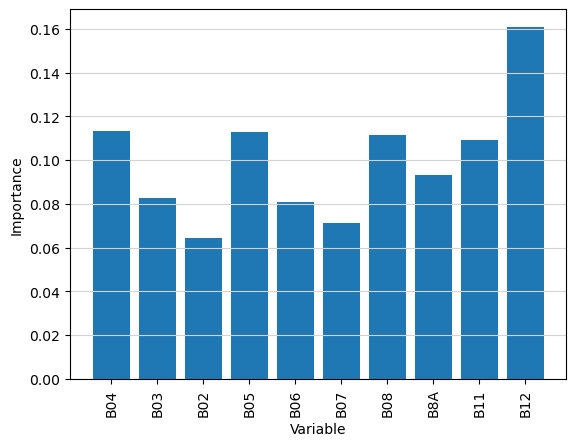

In [81]:
# Visualize the variables importances
plt.bar(characteristics, importances, orientation = 'vertical')
plt.xticks(rotation = 'vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.grid(axis = 'y', color = '#D3D3D3', linestyle = 'solid')
plt.show()